In [13]:
# Utilities
from pathlib import Path
import os
import subprocess as sp

# Data
import pandas as pd
import numpy as np

# Brain
import nibabel as nb
from nibabel.freesurfer.io import read_annot, read_label, read_morph_data
import cortex
import src.mesh_laplace_sulci

# Plotting
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt


In [17]:



# project_dir = Path('/Users/benparker/Desktop/cnl/CNL_scalpel/results/')
# subjects_dir = Path('/Users/benparker/Desktop/cnl/subjects/')
# subjects_dir_str = '/Users/benparker/Desktop/cnl/subjects/'

# ## read_annot returns [0] labels at each vertex, -1 for no id [1]: ctab [2]: label names 
# annot_verts, annot_ctab, annot_names = read_annot(subjects_dir / '100307/label/rh.aparc.a2009s.annot')


# # import test subject to pycortex db
# cortex.freesurfer.import_subj('100307', freesurfer_subject_dir=subjects_dir_str, whitematter_surf='white')


def read_label(label_name):
    """
    Reads a freesurfer-style .label file (5 columns)
    
    Parameters
    ----------
    label_name: str 
    
    Returns 
    -------
    vertices: index of the vertex in the label np.array [n_vertices] 
    RAS_coords: columns are the X,Y,Z RAS coords associated with vertex number in the label, np.array [n_vertices, 3] 
    
    """
    
    # read label file, excluding first two lines of descriptor 
    df_label = pd.read_csv(label_name,skiprows=[0,1],header=None,names=['vertex','x_ras','y_ras','z_ras','stat'],delimiter='\s+')
    
    vertices = np.array(df_label.vertex) 
    RAS_coords = np.empty(shape = (vertices.shape[0], 3))
    RAS_coords[:,0] = df_label.x_ras
    RAS_coords[:,1] = df_label.y_ras
    RAS_coords[:,2] = df_label.z_ras
    
    return vertices, RAS_coords



In [183]:
## Load labels for boundary sulci


vertices, coords = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')


def find_inferior_boundary(read_label):
    
      vertex_num = read_label[0]
      ras_coords = read_label[1]

      
      r_data = np.array([ras[0] for ras in ras_coords])
      a_data = np.array([ras[1] for ras in ras_coords])
      s_data = np.array([ras[2] for ras in ras_coords])

      inferior_boundary_coords = []
      inferior_boundary_vertex_num = []
      rounded_anterior = np.round(a_data, decimals=1)

    # for each rounded A value, find the vertex with the lowest S value
    # add vertex to inferior boundary
      for anterior in np.unique(rounded_anterior):
        # get all vertices with shared A coordinate
        column_idx = np.where(rounded_anterior == anterior)[0]
        # find minimum S coordinate from that column of points
        min_val = np.amin(s_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_min_idx = np.where(s_data == min_val)[0]
        column_min_idx = np.intersect1d(all_min_idx, column_idx)
        # add inferior boundary and vertex to list
        inferior_boundary_coords.append(list(ras_coords[column_min_idx][0]))
        inferior_boundary_vertex_num.append(vertex_num[column_min_idx])
#     for vertex in ras_coords:
      return np.array(inferior_boundary_vertex_num), np.array(inferior_boundary_coords)

r_data = np.array([ras[0] for ras in coords])
a_data = np.array([ras[1] for ras in coords])
s_data = np.array([ras[2] for ras in coords])

vert_num, verts = find_inferior_boundary([vertices, coords])


In [185]:
verts

array([[ -8.706, -30.928,  23.236],
       [ -8.508, -30.824,  23.453],
       [ -8.741, -30.686,  23.438],
       [ -8.427, -30.607,  23.449],
       [ -9.669, -30.459,  23.043],
       [ -8.55 , -30.436,  23.47 ],
       [ -9.567, -30.297,  27.656],
       [ -9.652, -30.193,  25.758],
       [ -8.388, -30.074,  23.789],
       [ -7.366, -29.99 ,  24.72 ],
       [-10.466, -29.867,  26.938],
       [ -9.466, -29.841,  22.659],
       [-10.445, -29.681,  22.789],
       [ -9.861, -29.586,  23.985],
       [ -8.653, -29.508,  23.409],
       [ -5.667, -29.354,  24.89 ],
       [ -3.589, -29.28 ,  25.277],
       [-10.035, -29.187,  22.   ],
       [-12.15 , -29.107,  26.238],
       [ -4.637, -29.038,  24.736],
       [-10.736, -28.881,  22.117],
       [ -9.185, -28.805,  22.605],
       [ -7.421, -28.7  ,  23.394],
       [ -6.35 , -28.484,  23.631],
       [-10.551, -28.45 ,  21.318],
       [ -7.634, -28.285,  23.041],
       [ -6.841, -28.206,  23.246],
       [ -5.484, -28.107,  2

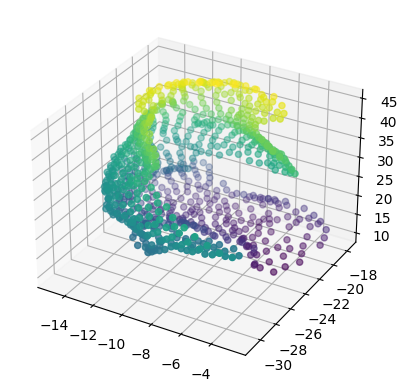

In [186]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

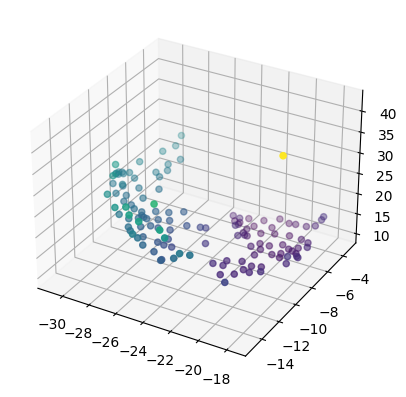

In [187]:
# Getting lower bound of the sulcus

r_data_min = np.array([ras[0] for ras in verts])
a_data_min = np.array([ras[1] for ras in verts])
s_data_min = np.array([ras[2] for ras in verts])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(a_data_min, r_data_min, s_data_min, cmap='viridis', c=s_data_min)

In [171]:
s_data_min.std()

5.921664702019811

In [33]:


## split FC map by boundary sulci

##### ID vertices within boundary by [0] from read annot

array([-30., -30., -31., -31., -30., -30., -31., -31., -31., -31., -30.,
       -31., -31., -31., -31., -31., -30., -30., -30., -31., -31., -31.,
       -31., -31., -30., -30., -30., -30., -31., -31., -30., -30., -30.,
       -31., -31., -31., -31., -30., -29., -29., -30., -30., -29., -29.,
       -30., -30., -29., -30., -30., -29., -28., -30., -30., -29., -29.,
       -29., -30., -30., -30., -31., -31., -30., -30., -29., -29., -29.,
       -29., -30., -30., -31., -31., -30., -29., -30., -30., -30., -28.,
       -29., -29., -28., -28., -29., -28., -28., -28., -28., -28., -28.,
       -28., -28., -28., -29., -29., -28., -28., -29., -29., -30., -30.,
       -29., -29., -28., -28., -28., -28., -29., -30., -30., -30., -28.,
       -28., -28., -28., -29., -29., -29., -28., -28., -28., -28., -28.,
       -27., -27., -27., -27., -27., -27., -28., -27., -27., -27., -28.,
       -27., -28., -28., -28., -28., -27., -28., -28., -28., -28., -28.,
       -27., -27., -27., -27., -27., -27., -27., -2